In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import mlflow
import os

In [96]:
def read_data_frame(file_path):
    df=pd.read_parquet(file_path)

    df['duration']=df.lpep_dropoff_datetime-df.lpep_pickup_datetime
    df.duration=df.duration.apply(lambda x:x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    return df
    
    

In [97]:
df_train=read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73908 entries, 0 to 76517
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               73908 non-null  int64         
 1   lpep_pickup_datetime   73908 non-null  datetime64[us]
 2   lpep_dropoff_datetime  73908 non-null  datetime64[us]
 3   store_and_fwd_flag     38175 non-null  object        
 4   RatecodeID             38175 non-null  float64       
 5   PULocationID           73908 non-null  object        
 6   DOLocationID           73908 non-null  object        
 7   passenger_count        38175 non-null  float64       
 8   trip_distance          73908 non-null  float64       
 9   fare_amount            73908 non-null  float64       
 10  extra                  73908 non-null  float64       
 11  mta_tax                73908 non-null  float64       
 12  tip_amount             73908 non-null  float64       
 13  tolls_

In [99]:
'''cat_col=df_train.select_dtypes(include='object')
   num_col=df_train.select_dtypes(exclude='object')'''

"cat_col=df_train.select_dtypes(include='object')\n   num_col=df_train.select_dtypes(exclude='object')"

In [100]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/tmp/ipykernel_115716/55724668.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)


<Axes: xlabel='duration', ylabel='Density'>

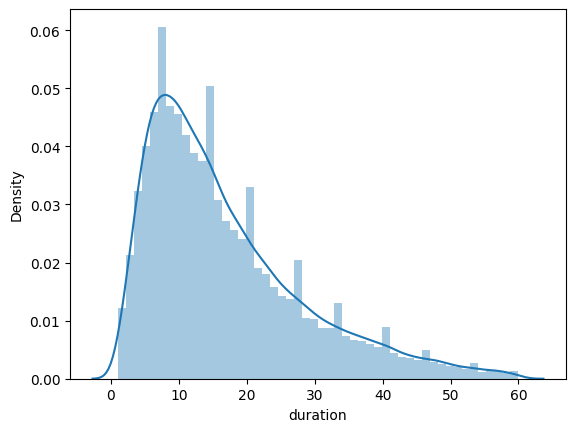

In [101]:
sns.distplot(df_train.duration)

In [102]:
df_train.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [103]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [104]:
df_train.duration.describe(percentiles=[.95,.98,.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [105]:
cat_cols = ['PULocationID', 'DOLocationID']
num_cols = ['trip_distance']
train_dicts=df_train[cat_cols+num_cols].to_dict(orient='records')
dv=DictVectorizer()
x_train=dv.fit_transform(train_dicts)
target='duration'
y_train=df_train[target].values
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_train)
mse=mean_squared_error(y_train, y_pred)
rmse=np.sqrt(mse)
rmse

2025/06/29 18:05:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ae8000f265ef4b9b91d10b0fdd9586d8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


9.838799799829628

/tmp/ipykernel_115716/1877227026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='Prediction')
/tmp/ipykernel_115716/1877227026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='Actual')


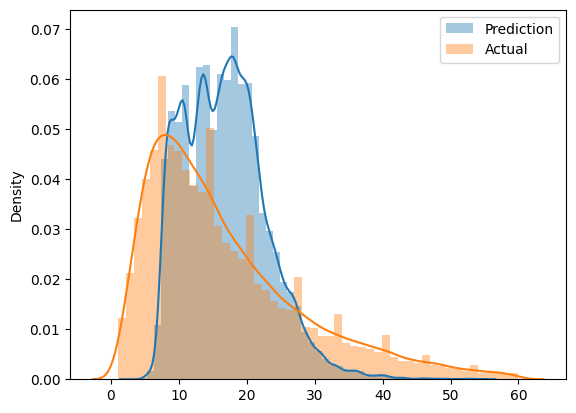

In [106]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [107]:
df_train['PU_DO']=df_train['PULocationID']+'_'+df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [108]:
cat_col=['PU_DO']
num_col=['trip_distance']
dv=DictVectorizer()
train_dicts=df_train[cat_col+num_col].to_dict(orient='records')
x_train=dv.fit_transform(train_dicts)
val_dicts = df_val[cat_col + num_col].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [109]:
target='duration'
y_train=df_train[target].values
y_val=df_val[target].values

In [110]:
lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_val)
mse=mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
rmse

2025/06/29 18:05:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '16374aefdacb4e6abf63283dc962eb7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


7.758715205596356

### Use Mlflow

In [111]:
os.makedirs('./Models',exist_ok=True)
with open('./Models/lin_rdge.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
    

In [112]:
import os
print(os.getcwd())

/home/ebrahim/MLOPS_ZOOMCAMP/02-experiment-tracking


In [113]:
mlflow.set_tracking_uri("http://localhost:5000") # tells mlflow where the tracking server
mlflow.set_experiment("Mlops_ZoomCamp_Experiement") # # creates or selects an experiment to log runs (like training ,metrics,models)

<Experiment: artifact_location='./mlruns/3', experiment_id='3', lifecycle_stage='active', name='Mlops_ZoomCamp_Experiement', tags={}>

In [114]:
with mlflow.start_run():
    mlflow.set_tag('developer','Ebrahim Emad')
    mlflow.log_param('train-data-path','https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path','https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    alpha=0.01
    mlflow.log_param('alpha',alpha)
    lr=Lasso(0.1)
    lr.fit(x_train,y_train)
    y_pred=lr.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric('rmse',rmse)
    mlflow.log_artifact('./Models/lin_rdge.bin', artifact_path='models_pickle')

2025/06/29 18:06:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 54dab1a527e947018f89e74966714842. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Changing param values is not allowed. Param with key=\'alpha\' was already logged with value=\'0.01\' for run ID=\'54dab1a527e947018f89e74966714842\'. Attempted logging new value \'0.1\'.")]')]


In [115]:
with mlflow.start_run():
    mlflow.sklearn.autolog()  # automatically logs parameters, metrics, and models
    alpha = 0.1
    lr = Lasso(alpha=alpha)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)

In [84]:
import xgboost as xgb
from hyperopt import fmin,hp,STATUS_OK,Trials
from hyperopt.pyll import scope
# use XGBoost's DMatrix :: which is a special data structure optimized for speed and memory
# convert the training and validation data into DMatrix format
train=xgb.DMatrix(x_train, label=y_train) 
valid=xgb.DMatrix(x_val, label=y_val)

In [85]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [86]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Range between exp(-3), and exp(0) == [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lamda': hp.loguniform('reg_lamda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1,
    trials=Trials()
)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32253                          
[1]	validation-rmse:6.77248                          
[2]	validation-rmse:6.66812                          
[3]	validation-rmse:6.63674                          
[4]	validation-rmse:6.62201                          
[5]	validation-rmse:6.60872                          
[6]	validation-rmse:6.60400                          
[7]	validation-rmse:6.59730                          
[8]	validation-rmse:6.59666                          
[9]	validation-rmse:6.59313                          
[10]	validation-rmse:6.59185                         
[11]	validation-rmse:6.59054                         
[12]	validation-rmse:6.58759                         
[13]	validation-rmse:6.58644                         
[14]	validation-rmse:6.58591                         
[15]	validation-rmse:6.58302                         
[16]	validation-rmse:6.58177                         
[17]	validation-rmse:6.58164                         
[18]	validation-rmse:6.58020

In [87]:
params = {
    'max_depth': 17,
    'learning_rate': 0.20472169880371677,
    'reg_alpha': 0.28567896734700793,
    'reg_lamda': 0.004264404814393109,
    'min_child_weight': 1.2402611720043835,
    'objective': 'reg:linear',
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2025/06/29 17:51:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2025/06/29 17:51:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4e8a8de3be784d7f88d1ae4cfee03c2b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.61602
[1]	validation-rmse:9.44614
[2]	validation-rmse:8.60401
[3]	validation-rmse:8.01180
[4]	validation-rmse:7.59760
[5]	validation-rmse:7.30899
[6]	validation-rmse:7.11229
[7]	validation-rmse:6.97328
[8]	validation-rmse:6.87539
[9]	validation-rmse:6.80545
[10]	validation-rmse:6.75522
[11]	validation-rmse:6.71690
[12]	validation-rmse:6.68955
[13]	validation-rmse:6.66975
[14]	validation-rmse:6.65156
[15]	validation-rmse:6.63964
[16]	validation-rmse:6.62926
[17]	validation-rmse:6.62080
[18]	validation-rmse:6.61495
[19]	validation-rmse:6.61072
[20]	validation-rmse:6.60481
[21]	validation-rmse:6.60252
[22]	validation-rmse:6.60168
[23]	validation-rmse:6.59882
[24]	validation-rmse:6.59752
[25]	validation-rmse:6.59541
[26]	validation-rmse:6.59393
[27]	validation-rmse:6.59220
[28]	validation-rmse:6.59095
[29]	validation-rmse:6.58905
[30]	validation-rmse:6.58806
[31]	validation-rmse:6.58584
[32]	validation-rmse:6.58418
[33]	validation-rmse:6.58340
[34]	validation-rmse:6.

2025/06/29 17:51:30 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/06/29 17:51:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:51:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/06/29 17:51:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: No module named 'distutils._modified'


In [88]:
mlflow.xgboost.autolog(disable=True)

In [91]:
with mlflow.start_run():
    best_params = {
        'max_depth': 17,
        'learning_rate': 0.20472169880371677,
        'reg_alpha': 0.28567896734700793,
        'reg_lamda': 0.004264404814393109,
        'min_child_weight': 1.2402611720043835,
        'objective': 'reg:linear',
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open('Models/preprocessor.b', 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
    
    mlflow.log_artifact("Models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.61602
[1]	validation-rmse:9.44614
[2]	validation-rmse:8.60401
[3]	validation-rmse:8.01180
[4]	validation-rmse:7.59760
[5]	validation-rmse:7.30899
[6]	validation-rmse:7.11229
[7]	validation-rmse:6.97328
[8]	validation-rmse:6.87539
[9]	validation-rmse:6.80545
[10]	validation-rmse:6.75522
[11]	validation-rmse:6.71690
[12]	validation-rmse:6.68955
[13]	validation-rmse:6.66975
[14]	validation-rmse:6.65156
[15]	validation-rmse:6.63964
[16]	validation-rmse:6.62926
[17]	validation-rmse:6.62080
[18]	validation-rmse:6.61495
[19]	validation-rmse:6.61072
[20]	validation-rmse:6.60481
[21]	validation-rmse:6.60252
[22]	validation-rmse:6.60168
[23]	validation-rmse:6.59882
[24]	validation-rmse:6.59752
[25]	validation-rmse:6.59541
[26]	validation-rmse:6.59393
[27]	validation-rmse:6.59220
[28]	validation-rmse:6.59095
[29]	validation-rmse:6.58905
[30]	validation-rmse:6.58806
[31]	validation-rmse:6.58584
[32]	validation-rmse:6.58418
[33]	validation-rmse:6.58340
[34]	validation-rmse:6.

/home/ebrahim/miniconda3/envs/mlflow_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [92]:
logged_model = 'runs:/16039d6a17634d9991d988b6cb367857/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 16039d6a17634d9991d988b6cb367857

In [93]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model

In [94]:
y_pred = xgboost_model.predict(valid)

y_pred[:10]

array([14.422148 ,  7.2832036, 15.511797 , 24.380302 ,  9.07571  ,
       17.124989 , 11.194462 ,  8.594795 ,  8.980683 , 18.265078 ],
      dtype=float32)